In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error,r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer


In [23]:
# Load the data into a pandas dataframe
df = pd.read_csv('C:/Users/Checkout/Documents/Courses/GWAR/Datasets/Monthly_aggregated_ccsd.csv')

In [24]:
pd.set_option('display.max_columns', None)
df.head()

,county,Date,T2MDEW,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,Month,Year,Lat,Lon,T2M,PRECTOTCORR,SPEI_1,None,D0-D4,D1-D4,D2-D4,D3-D4,D4,DSCI
0,Alameda County,2000-01-31,7.107419,9.116452,7.450968,13.780806,6.329032,6.428226,86.010484,100.415645,3.130323,4.973226,1.657903,3.316129,218.273548,1,2000,37.609029,-121.899142,9.723036,4.953214,-0.900588,72.2125,27.7875,0.0,0.0,0.0,0.0,27.75
1,Alameda County,2000-02-29,8.242414,9.986034,7.142759,14.223448,7.080517,6.871034,87.533621,99.961897,3.887759,5.794655,2.063793,3.730517,181.979828,2,2000,37.609029,-121.899142,10.303103,6.548448,-1.189093,100.0000,0.0000,0.0,0.0,0.0,0.0,0.00
2,Alameda County,2000-03-31,7.236613,10.625161,10.083065,15.979355,5.897097,6.400323,82.083226,100.094032,3.739194,5.400323,2.256452,3.144839,255.344677,3,2000,37.609029,-121.899142,10.441452,1.324839,0.450381,100.0000,0.0000,0.0,0.0,0.0,0.0,0.00
3,Alameda County,2000-04-30,8.843500,13.539000,11.147333,19.142833,7.995167,7.147500,78.699500,100.078500,3.814500,5.520833,2.290667,3.230500,250.417333,4,2000,37.609029,-121.899142,12.949500,1.127167,-0.036886,100.0000,0.0000,0.0,0.0,0.0,0.0,0.00
4,Alameda County,2000-05-31,9.792742,16.271774,12.337581,22.173871,9.836774,7.698710,73.919194,99.836935,4.315645,6.068710,2.772258,3.295806,267.711613,5,2000,37.609029,-121.899142,15.370484,0.899194,-0.945058,100.0000,0.0000,0.0,0.0,0.0,0.0,0.00


In [25]:
df['Date'] = pd.to_datetime(df['Date'])
# Select the columns you want to keep for training
# train_cols = ['T2M', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'WS10M' ,'PRECTOTCORR', 'SPEI_1', 'D1-D4','D0-D4','Date']

In [5]:
df= df.rename(columns={'WS10M':'NDVI'})
# Select the columns you want to keep for training
train_cols = ['T2M', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'WS10M' ,'PRECTOTCORR','SPEI_1','NDVI','D0-D4','']


In [26]:

train_cols = ['T2M', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'WS10M' ,'PRECTOTCORR', 'SPEI_1', 'D1-D4','D0-D4','Date','county']



# Drop the columns you don't need
df = df[train_cols]

# Split the data into train, validation, and test sets
train_data = df.loc[df['Date'].dt.year.between(2000, 2018)]
val_data = df.loc[df['Date'].dt.year == 2019]
test_data = df.loc[df['Date'].dt.year == 2020]
print(f"Train set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")

Train set shape: (11628, 11)
Validation set shape: (612, 11)
Test set shape: (612, 11)


In [29]:
def label_drought(row):
    if row['D0-D4'] == 0:
        return 'No drought'
    elif row['D0-D4'] <= 20:
        return 'Mild Drought'
    elif row['D0-D4'] <= 50:
        return 'Moderate Drought'
    elif row['D0-D4'] <= 80:
        return 'Severe Drought'
    else:
        return 'Extreme Drought'

df['Drought Level'] = df.apply(lambda row: label_drought(row), axis=1)
df.head()

,T2M,T2M_MAX,T2M_MIN,RH2M,WS10M,PRECTOTCORR,D0-D4,Drought Level
0,9.723036,13.780806,6.329032,86.010484,3.130323,4.953214,27.7875,Moderate Drought
1,10.303103,14.223448,7.080517,87.533621,3.887759,6.548448,0.0000,No drought
2,10.441452,15.979355,5.897097,82.083226,3.739194,1.324839,0.0000,No drought
3,12.949500,19.142833,7.995167,78.699500,3.814500,1.127167,0.0000,No drought
4,15.370484,22.173871,9.836774,73.919194,4.315645,0.899194,0.0000,No drought


In [ ]:
df['SPEI_1'] = df['SPEI_1'].astype('float64')

In [ ]:
row = df[df['SPEI_1'] == '4.52660714285714;1.505']
row

In [5]:
df['SPEI_1'] = pd.to_numeric(df['SPEI_1'], errors='coerce')
nan_rows = df[df['SPEI_1'].isna()]
nan_rows

,county,Date,T2M,T2MDEW,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PS,WS10M,PRECTOTCORR,WD10M,SPEI_1,D0-D4


In [23]:
df.isnull().sum()

T2M            0
T2M_MAX        0
T2M_MIN        0
RH2M           0
WS10M          0
PRECTOTCORR    0
SPEI_1         0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12852 entries, 0 to 12851
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   T2M          12852 non-null  float64
 1   T2M_MAX      12852 non-null  float64
 2   T2M_MIN      12852 non-null  float64
 3   RH2M         12852 non-null  float64
 4   WS10M        12852 non-null  float64
 5   PRECTOTCORR  12852 non-null  float64
 6   SPEI_1       12852 non-null  float64
dtypes: float64(7)
memory usage: 703.0 KB


In [39]:
train_X, train_y = train_data.iloc[:, :-1], train_data.iloc[:, -1]
val_X, val_y = val_data.iloc[:, :-1], val_data.iloc[:, -1]
test_X, test_y = test_data.iloc[:, :-1], test_data.iloc[:, -1]

#Scale the data
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)
test_X = scaler.transform(test_X)

# #Decision Tree Regressor
# dt = DecisionTreeRegressor(random_state=0)
# dt.fit(train_X, train_y)
# dt_pred = dt.predict(test_X)
# dt_mse = mean_squared_error(test_y, dt_pred)
# dt_mae = mean_absolute_error(test_y, dt_pred)
# dt_r2  = r2_score(test_y, dt_pred)
# print("Decision Tree MSE:", dt_mse)
# print("Decision Tree MAE:", dt_mae)
# print("Decision Tree R2 Score:",dt_r2*100)

#XGBoost with Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=0)
xgb = XGBRegressor(base_estimator=dt, n_estimators=100, random_state=0)
xgb.fit(train_X, train_y)
xgb_pred = xgb.predict(test_X)
xgb_mse = mean_squared_error(test_y, xgb_pred)
xgb_mae = mean_absolute_error(test_y, xgb_pred)
xgb_r2 = r2_score(test_y, xgb_pred)
print("XGBoost with Decision Tree MSE:", xgb_mse)
print("XGBoost with Decision Tree MAE:", xgb_mae)
print("XGBoost with Decision Tree R2 Score:", xgb_r2*100)

#Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(train_X, train_y)
rf_pred = rf.predict(test_X)
rf_mse = mean_squared_error(test_y, rf_pred)
rf_mae = mean_absolute_error(test_y, rf_pred)
rf_r2  = r2_score(test_y, rf_pred)
print("Random Forest MSE:", rf_mse)
print("Random Forest MAE:", rf_mae)
print("Random Forest R2 Score:",rf_r2*100)

#LSTM
#Normalize target variable
scaler_y = MinMaxScaler()
train_y = scaler_y.fit_transform(train_y.values.reshape(-1, 1))
val_y = scaler_y.transform(val_y.values.reshape(-1, 1))
test_y = scaler_y.transform(test_y.values.reshape(-1, 1))

lstm_train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
lstm_val_X = np.reshape(val_X, (val_X.shape[0], 1, val_X.shape[1]))
lstm_test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(lstm_train_X.shape[1], lstm_train_X.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')

lstm_model.fit(lstm_train_X, train_y, epochs=30, batch_size=32, validation_data=(lstm_val_X, val_y), verbose=2, shuffle=False)
lstm_pred = lstm_model.predict(lstm_test_X)
lstm_pred = scaler_y.inverse_transform(lstm_pred)
test_y = scaler_y.inverse_transform(test_y)

lstm_mse = mean_squared_error(test_y, lstm_pred)
lstm_mae = mean_absolute_error(test_y, lstm_pred)
lstm_r2  = r2_score(test_y, lstm_pred)
print("LSTM MSE:", lstm_mse)
print("LSTM MAE:", lstm_mae)
print("LSTM R2 Score:",lstm_r2*100)

#ANN
ann_model = Sequential()
ann_model.add(Dense(100, input_dim=train_X.shape[1], activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(1))
ann_model.compile(loss='mse', optimizer='adam')

ann_model.fit(train_X, train_y, epochs=30, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)
ann_pred = ann_model.predict(test_X)
ann_pred = scaler_y.inverse_transform(ann_pred)
ann_mse = mean_squared_error(test_y, ann_pred)
ann_mae = mean_absolute_error(test_y, ann_pred)
ann_r2  = r2_score(test_y, ann_pred)
print("ANN MSE:", ann_mse)
print("ANN MAE:", ann_mae)
print("ANN R2 Score:",ann_r2*100)

[18:49:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "base_estimator" } are not used.

XGBoost with Decision Tree MSE: 0.25429730802083816
XGBoost with Decision Tree MAE: 0.392294319766112
XGBoost with Decision Tree R2 Score: 71.65989884632256
Random Forest MSE: 0.2467555440517315
Random Forest MAE: 0.3836177071150855
Random Forest R2 Score: 72.50038888306382
Epoch 1/30
290/290 - 8s - loss: 0.0479 - val_loss: 0.0309 - 8s/epoch - 27ms/step
Epoch 2/30
290/290 - 2s - loss: 0.0262 - val_loss: 0.0245 - 2s/epoch - 5ms/step
Epoch 3/30
290/290 - 2s - loss: 0.0226 - val_loss: 0.0229 - 2s/epoch - 5ms/step
Epoch 4/30
290/290 - 1s - loss: 0.0213 - val_loss: 0.0219 - 1s/epoch - 5ms/step
Epoch 5/30
290/290 - 2s - loss: 0.0205 - val_loss: 0.0210 - 2s/epoch - 5ms/step
Epoch 6/30
290/290 - 1s - loss: 0.0196 - val_loss: 0.0200 - 1s/epoch - 5ms/step
Epoch 7/30
290/290 - 2s - loss: 0.0185 -

In [26]:
from sklearn.preprocessing import MinMaxScaler

# select columns for scaling
cols_to_scale = ['T2M', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'WS10M', 'PRECTOTCORR', 'SPEI_1']

# apply Min-Max scaling
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# split the data into train, validate and test sets
train_data = df.loc[df['Date'].dt.year.between(2000, 2018)]
val_data = df.loc[df['Date'].dt.year == 2019]
test_data = df.loc[df['Date'].dt.year == 2020]

# separate target variable from features
X_train = train_data[train_cols[:-1]]
y_train = train_data[train_cols[-1]]

X_val = val_data[train_cols[:-1]]
y_val = val_data[train_cols[-1]]

X_test = test_data[train_cols[:-1]]
y_test = test_data[train_cols[-1]]

# fit the Random Forest Regressor on train data
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# evaluate the model on validation data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = rf.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

mae=7.61
mse=43.28
rmse=6.57
r2=0.70

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)


# # select a random index from the validation set
# rand_idx = random.choice(val_data.index)

# # get the corresponding features and target variable for that index
# features = X_val.loc[rand_idx].values.reshape(1, -1)
# target = y_val.loc[rand_idx]

# # get the predicted value from the model
# pred = rf.predict(features)[0]

# # print the prediction and actual values
# print("Prediction:", pred)
# print("Actual Value:", target)


MAE: 7.61
MSE: 43.28
RMSE: 6.57
R2 Score: 0.7


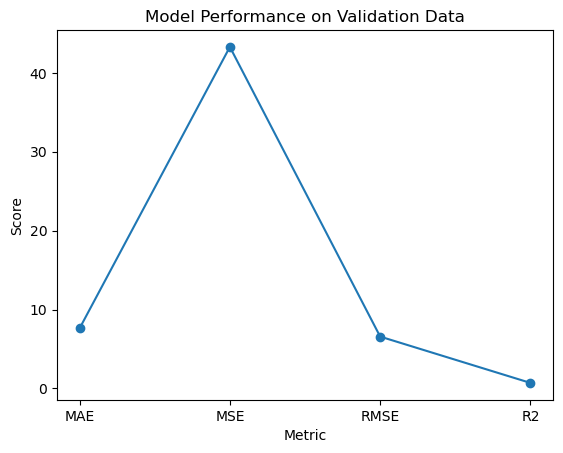

In [27]:
# create a list of metric scores
metric_scores = [mae, mse, rmse, r2]

# create a list of metric names
metric_names = ['MAE', 'MSE', 'RMSE', 'R2']

# plot line plot
plt.plot(metric_names, metric_scores, marker='o')

# set axis labels and title
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance on Validation Data')

# display plot
plt.show()

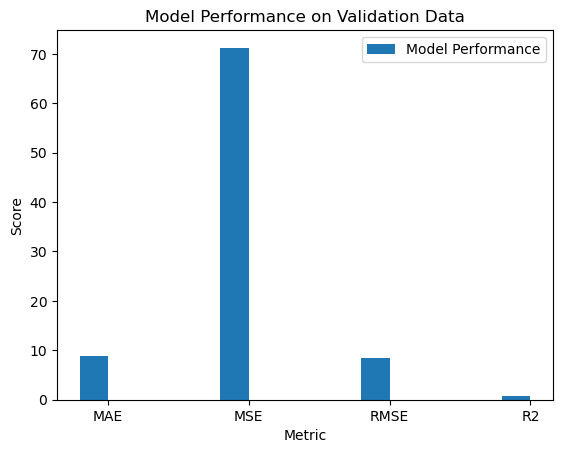

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# create a list of metric scores
metric_scores = [mae, mse, rmse, r2]

# create a list of metric names
metric_names = ['MAE', 'MSE', 'RMSE', 'R2']

# define the bar width
bar_width = 0.2

# create arrays for the x coordinates of the bars
x_pos1 = np.arange(len(metric_scores))
x_pos2 = x_pos1 + bar_width

# create the figure and axis objects
fig, ax = plt.subplots()

# create the bar plots
ax.bar(x_pos1, metric_scores, bar_width, label='Model Performance')

# set axis labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Model Performance on Validation Data')

# set the x-ticks and labels
ax.set_xticks(x_pos1 + bar_width / 2)
ax.set_xticklabels(metric_names)

# display the legend
ax.legend()

# display the plot
plt.show()


In [29]:
# select columns for scaling
cols_to_scale = ['T2M', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'WS10M', 'PRECTOTCORR', 'SPEI_1']

# apply Min-Max scaling
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# split the data into train, validate and test sets
train_data = df.loc[df['Date'].dt.year.between(2000, 2018)]
val_data = df.loc[df['Date'].dt.year == 2019]
test_data = df.loc[df['Date'].dt.year == 2020]

# separate target variable from features
X_train = train_data[train_cols[:-1]]
y_train = train_data[train_cols[-1]]

X_val = val_data[train_cols[:-1]]
y_val = val_data[train_cols[-1]]

X_test = test_data[train_cols[:-1]]
y_test = test_data[train_cols[-1]]

# define the search space for hyperparameters
search_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(2, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0)
}

# create a Random Forest Regressor object
rf = RandomForestRegressor(random_state=42)

# define the BayesSearchCV object
clf = BayesSearchCV(rf, search_space, n_iter=32, cv=5, n_jobs=-1)

# fit the BayesSearchCV object on train data
clf.fit(X_train, y_train)

print("Best Hyperparameters: ", clf.best_params_)

mae=6.81
mse=39.73
rmse=6.3
r2=0.74

# evaluate the best model on validation data
y_pred = clf.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)


Best Hyperparameters:  OrderedDict([('max_depth', 18), ('max_features', 0.9991242998138145), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 423)])
MAE: 19.498437938808088
MSE: 670.0255271972557
RMSE: 25.884851307227084
R2 Score: 0.3900043600539165


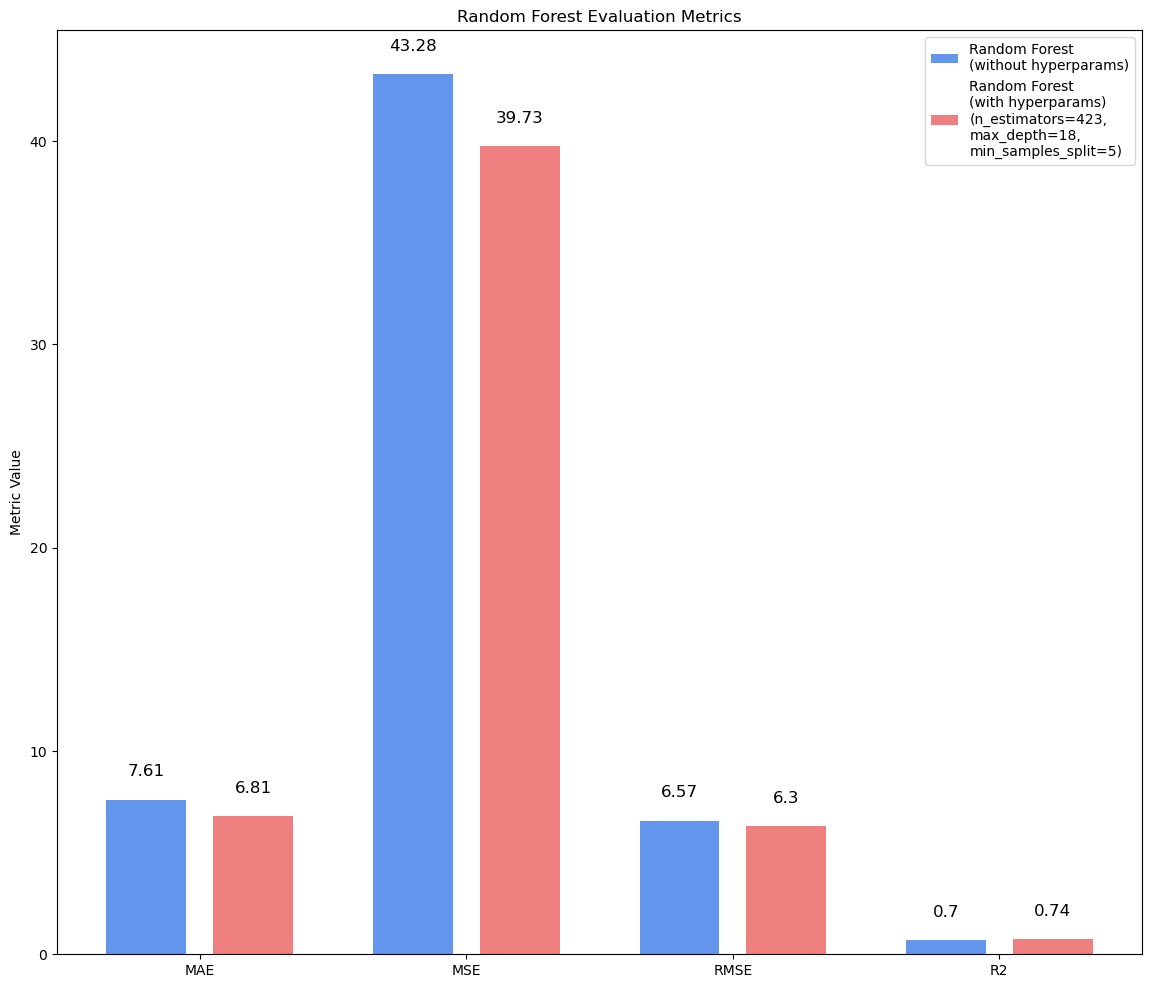

In [44]:
import matplotlib.pyplot as plt

# Define the MAE, MSE, RMSE, and R2 values for both models
no_hyperparams = [7.61, 43.28, 6.57, 0.70]
hyperparams = [6.81, 39.73, 6.3, 0.74]

# Define the labels for the x-axis (i.e., the metric names)
metric_labels = ['MAE', 'MSE', 'RMSE', 'R2']

# Define the labels for the bars (i.e., the model names with hyperparameters)
bar_labels = ['Random Forest\n(without hyperparams)', 'Random Forest\n(with hyperparams)\n(n_estimators=423,\nmax_depth=18,\nmin_samples_split=5)']

# Define the colors for the bars
bar_colors = ['cornflowerblue', 'lightcoral']

# Set the size of the plot
fig, ax = plt.subplots(figsize=(14, 12))

# Set the positions of the bars
bar_positions1 = [0, 1, 2, 3]
bar_positions2 = [x + 0.4 for x in bar_positions1]

# Plot the bars
ax.bar(bar_positions1, no_hyperparams, width=0.3, color=bar_colors[0], label=bar_labels[0])
ax.bar(bar_positions2, hyperparams, width=0.3, color=bar_colors[1], label=bar_labels[1])

# Add the metric values above the bars
for i, val in enumerate(no_hyperparams):
    ax.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=12)
for i, val in enumerate(hyperparams):
    ax.text(i + 0.4, val + 1, str(val), ha='center', va='bottom', fontsize=12)

# Set the x-axis tick labels
ax.set_xticks([x + 0.2 for x in bar_positions1])
ax.set_xticklabels(metric_labels)

# Set the y-axis label
ax.set_ylabel('Metric Value')

# Set the title of the plot
ax.set_title('Random Forest Evaluation Metrics')

# Add a legend
ax.legend()

# Show the plot
plt.show()
